# Data Review
**Contents**
1. Global config
2. Load multi-year datasets (2020–2025)
3. Annual overview: total sites/samples + surface/subsurface
4. Land-use coverage by year (sites & samples)
5. Regional coverage by year (sites & samples)
6. Indicator availability by year (Exists / HasData)
7. Indicator availability by land-use (Exists / HasData)
8. Save all results to Excel

**Design goals**
- Single-source configuration
- Robust checks (missing sheets/columns)
- Consistent table shapes (rows=category, cols=years)
- Step-by-step visibility in notebook cells

## 0 Imports & Display Settings

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

## 1 Global Config

In [2]:
# Project root (EDIT THIS)
PROJECT_ROOT = r"D:/实习/工作/1_遥感检测土壤污染/EAD to GSS"

# Years to be loaded (EDIT if needed)
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]

# File template (relative to PROJECT_ROOT)
FILE_TEMPLATE = r"Soil quality data/Soil quality data {year}.xlsx"

# Required sheets
REQUIRED_SHEETS = ["PHChemical"]

# Required columns in PHChemical (minimal set for this notebook)
REQUIRED_PHC_COLS = ["SurveyID", "SiteUID", "PHUID", "Location"]

# Surface/Subsurface definition (based on your earlier convention)
PHUID_SURFACE = 1
PHUID_SUBSURFACE = 3

# Land-use mapping (SurveyID -> Name)
LANDUSE_MAP = {
    7: "Agricultural",
    8: "Residential",
    9: "Industrial",
    11: "Non-developed",
}

# Regions list (Location)
REGIONS = ["Abu Dhabi", "Al Ain", "Al Dhafra"]

# Output settings
OUTPUT_DIR = os.path.join(PROJECT_ROOT, r"Result_hmq/Data Review")
OUTPUT_EXCEL_NAME = "Data_Review_Summary.xlsx"

# If you do not want to write files during debugging, set False
EXPORT_TO_EXCEL = False

## 2 Utility Functions

In [3]:
def ensure_dir(path: str) -> str:
    """Create directory if missing."""
    os.makedirs(path, exist_ok=True)
    return path

def assert_sheets_exist(data: dict, year: int, required_sheets: list) -> None:
    """Raise a clear error if any required sheet is missing."""
    missing = [s for s in required_sheets if s not in data]
    if missing:
        raise KeyError(f"[{year}] Missing required sheets: {missing}. Available sheets: {list(data.keys())}")

def require_columns(df: pd.DataFrame, cols: list, df_name: str) -> None:
    """Raise a clear error if any required column is missing."""
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{df_name} missing required columns: {missing}\nAvailable columns (head): {list(df.columns)[:40]}")

def dedup_keep_order(seq):
    """De-duplicate list but keep original order."""
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

def load_all_years(project_root: str, years: list, file_template: str, required_sheets: list) -> dict:
    """
    Load all years into a nested dict:
    data_dict[year] -> {sheet_name: DataFrame}
    """
    data_dict = {}
    for y in years:
        fp = os.path.join(project_root, file_template.format(year=y))
        if not os.path.exists(fp):
            raise FileNotFoundError(f"File not found for year={y}: {fp}")
        data = pd.read_excel(fp, sheet_name=None)
        assert_sheets_exist(data, y, required_sheets)
        data_dict[y] = data
    return data_dict

def get_phchemical(data_dict: dict, year: int) -> pd.DataFrame:
    """Fetch PHChemical and validate minimal schema."""
    phc = data_dict[year]["PHChemical"].copy()
    require_columns(phc, REQUIRED_PHC_COLS, df_name=f"[{year}] PHChemical")
    return phc

def make_category_year_tables(values, years, fill_value=0, dtype=int):
    """
    Create a (rows=category, cols=year) DataFrame initialized with fill_value.
    values: list of category names (row labels)
    years: list of years (col labels)
    """
    return pd.DataFrame(fill_value, index=values, columns=years, dtype=dtype)


## 3 Load Multi-year Datasets

In [5]:
data_dict = load_all_years(PROJECT_ROOT, YEARS, FILE_TEMPLATE, REQUIRED_SHEETS)

print(f"Loaded years: {list(data_dict.keys())}")
print(f"Example sheets in {YEARS[0]}: {list(data_dict[YEARS[0]].keys())[:10]}")

# Show the first few rows of PHChemical for sanity check
phc_2020 = get_phchemical(data_dict, YEARS[0])
display(phc_2020.head())

Loaded years: [2020, 2021, 2022, 2023, 2024, 2025]
Example sheets in 2020: ['Survey', 'PedonHorizon', 'PHChemical', 'PHPhysical', 'PHSample']


,SurveyID,SiteUID,SiteObsUID,PedonUID,PHUID,PHSampleUID,PHSubSampleUID,PHChemicalUID,Longitude,Latitude,obsdate,Location,Arsenic,Beryllium,Cadmium,Lead_aqua,Copper,Iron_aqua,InorganicMercury,Nickel_aqua,Zinc,Selenium_aqua,Antimony,Cobalt,Molybdenum,Vanadium,TiCl4,satB_mgl,satph,satec,TotalKjeldahlNitrogen_TKN,TotalOrganicCarbon,Acenaphthene,Acenaphthylene,Anthracene,Benzo_a_anthracene,Benzo_a_pyrene,Benzo_b_fluoranthene,Benzo_g_h_i_perylene,Benzo_k_fluoranthene,Chrysene,Dibenz_a_h_anthracene,Fluoranthene,Fluorene,Indeno_1_2_3_c_d_pyrene,Naphthalene,Phenanthrene,Pyrene,Total_PAHs_BaP_equivalents
0,8,1000424915,3,2,1,1,1,1,54.372022,24.506177,2020-03-23,Abu Dhabi,1.8,0.1,0.09,2.8,NaN,NaN,NaN,29.6,34.7,0.35,0.21,2.8,0.42,NaN,NaN,NaN,8.0,0.807,1652.0,2.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1000424915,3,2,3,1,1,1,54.372022,24.506177,2020-03-23,Abu Dhabi,2.3,0.14,0.11,3.4,NaN,NaN,NaN,45.8,12.6,0.37,0.16,4.7,0.37,NaN,NaN,NaN,7.7,1.198,275.0,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,10004103517,3,2,1,1,1,1,54.363082,24.497118,2020-03-23,Abu Dhabi,2.6,0.21,0.14,5.9,NaN,NaN,NaN,33.0,60.9,0.51,0.27,5.1,0.59,NaN,NaN,NaN,7.9,1.103,886.0,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,10004103517,3,2,3,1,1,1,54.363082,24.497118,2020-03-23,Abu Dhabi,1.9,0.14,0.12,1.6,NaN,NaN,NaN,19.0,9.3,0.32,0.14,3.0,0.37,NaN,NaN,NaN,8.2,0.769,326.0,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1000414363,3,2,1,1,1,1,54.362811,24.492383,2020-03-23,Abu Dhabi,2.6,0.16,0.3,7.5,NaN,NaN,NaN,36.8,46.5,0.45,0.34,4.4,0.67,NaN,NaN,NaN,8.0,0.383,907.0,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4 Annual Overview: total sites/samples + surface/subsurface
**Output table**: one row per year

In [6]:
annual_overview_rows = []

for y in YEARS:
    phc = get_phchemical(data_dict, y)

    # Basic counts
    total_sites = phc["SiteUID"].nunique()
    total_samples = len(phc)

    # Surface / subsurface counts (by PHUID)
    surface_samples = int((phc["PHUID"] == PHUID_SURFACE).sum())
    subsurface_samples = int((phc["PHUID"] == PHUID_SUBSURFACE).sum())

    annual_overview_rows.append({
        "Year": y,
        "Total_Sites": total_sites,
        "Total_Samples": total_samples,
        "Surface_Samples": surface_samples,
        "Subsurface_Samples": subsurface_samples,
    })

df_annual_overview = pd.DataFrame(annual_overview_rows).sort_values("Year").reset_index(drop=True)

display(df_annual_overview)

,Year,Total_Sites,Total_Samples,Surface_Samples,Subsurface_Samples
0,2020,295,619,310,309
1,2021,365,768,384,384
2,2022,560,1174,587,587
3,2023,700,1468,734,734
4,2024,625,1310,655,655
5,2025,709,743,743,0


## 5 Land-use Coverage by Year (Sites & Samples)
**Two output tables**:
- df_landuse_sites: rows=LandUse, cols=Year
- df_landuse_samples: rows=LandUse, cols=Year

In [7]:
landuse_names = list(LANDUSE_MAP.values())

df_landuse_sites = make_category_year_tables(landuse_names, YEARS, fill_value=0, dtype=int)
df_landuse_samples = make_category_year_tables(landuse_names, YEARS, fill_value=0, dtype=int)

for y in YEARS:
    phc = get_phchemical(data_dict, y)

    for survey_id, landuse in LANDUSE_MAP.items():
        sub = phc[phc["SurveyID"] == survey_id]

        df_landuse_sites.loc[landuse, y] = int(sub["SiteUID"].nunique())
        df_landuse_samples.loc[landuse, y] = int(len(sub))

print("Land-use Sites table:")
display(df_landuse_sites)

print("Land-use Samples table:")
display(df_landuse_samples)

Land-use Sites table:


,2020,2021,2022,2023,2024,2025
Agricultural,100,100,310,306,306,306
Residential,69,81,81,150,150,150
Industrial,116,169,169,169,169,169
Non-developed,0,15,0,75,0,84


Land-use Samples table:


,2020,2021,2022,2023,2024,2025
Agricultural,210,210,650,642,642,321
Residential,149,170,170,314,314,157
Industrial,240,356,354,354,354,177
Non-developed,0,32,0,158,0,88


## 5.1 Visualization: Land-use Coverage (Sites vs Samples)
Rounded-pill bar chart showing number of sites (front) and samples (back)
for each land-use category and year.

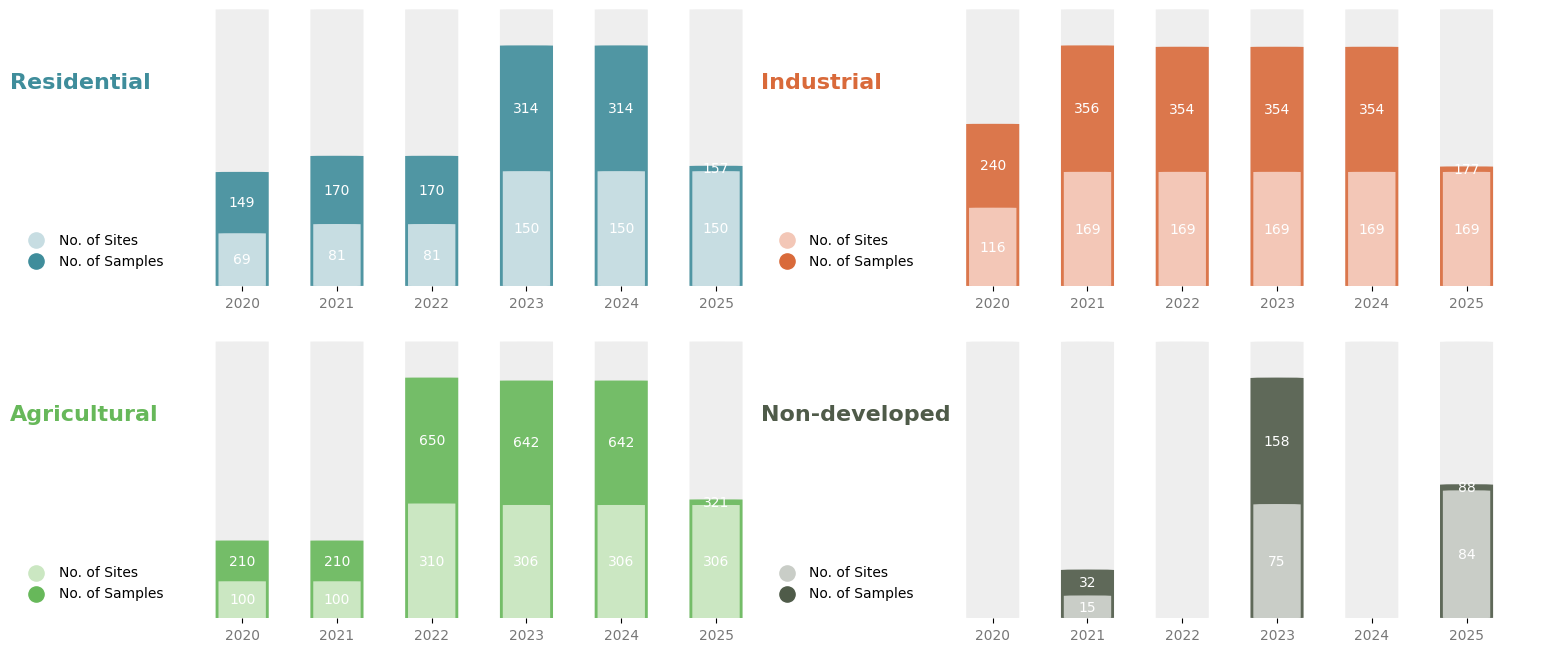

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

# -------------------------
# Prepare data from tables
# -------------------------

years = YEARS  # reuse global YEARS config

# Ensure consistent land-use order
LANDUSE_ORDER = ["Residential", "Industrial", "Agricultural", "Non-developed"]

# Build plotting data directly from summary tables
plot_data = {}
for lu in LANDUSE_ORDER:
    plot_data[lu] = {
        "sites": df_landuse_sites.loc[lu, years].values.tolist(),
        "samples": df_landuse_samples.loc[lu, years].values.tolist(),
    }

# Panel colors: (sites_front_light, samples_back_dark)
colors = {
    "Residential":    ("#C7DDE2", "#3F8D9B"),
    "Industrial":     ("#F3C7B7", "#D96A3A"),
    "Agricultural":   ("#CBE7C2", "#67B85A"),
    "Non-developed":  ("#C9CDC7", "#4F5B49"),
}

BG_PILL = "#EEEEEE"


def pill(ax, x_center, y0, height, width, color, alpha=1.0, z=1):
    """
    Draw a rounded 'pill' rectangle in data coordinates.
    """
    if height <= 0:
        return
    x0 = x_center - width / 2
    r = width / 2
    patch = FancyBboxPatch(
        (x0, y0), width, height,
        boxstyle=f"round,pad=0,rounding_size={r}",
        linewidth=0,
        facecolor=color,
        alpha=alpha,
        zorder=z
    )
    ax.add_patch(patch)


def draw_panel(ax, title, years, sites, samples, site_color, sample_color):
    """
    Draw one land-use panel.
    Back pill: samples
    Front pill: sites
    """
    years = list(years)
    sites = np.array(sites, dtype=float)
    samples = np.array(samples, dtype=float)

    max_v = max(samples.max(), sites.max(), 1.0)
    full_h = max_v * 1.15  # background height

    x = np.arange(len(years))
    w_back = 0.56   # samples width
    w_front = 0.50  # sites width

    # background gray pills
    for xi in x:
        pill(ax, xi, 0, full_h, w_back, BG_PILL, alpha=1.0, z=0)

    # data pills
    for xi, s_site, s_samp in zip(x, sites, samples):
        # samples (back)
        pill(ax, xi, 0, s_samp, w_back, sample_color, alpha=0.90, z=2)
        # sites (front)
        pill(ax, xi, 0, s_site, w_front, site_color, alpha=1.0, z=3)

        # labels
        if s_site > 0:
            ax.text(
                xi, max(s_site * 0.5, full_h * 0.04),
                f"{int(s_site)}",
                ha="center", va="center",
                fontsize=10, color="white", zorder=10
            )

        if s_samp > 0:
            y_samp = s_site + (s_samp - s_site) * 0.5 if s_samp > s_site else s_samp * 0.5
            ax.text(
                xi, y_samp,
                f"{int(s_samp)}",
                ha="center", va="center",
                fontsize=10, color="white", zorder=9
            )

    # styling
    ax.text(
        -0.25, 0.7, title,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        color=sample_color,
        ha="left",
        va="bottom"
    )

    ax.set_xticks(x)
    ax.set_xticklabels(years, fontsize=10, color="#777777")
    ax.set_xlim(-0.8, len(years) - 0.2)
    ax.set_ylim(0, full_h)
    ax.spines[:].set_visible(False)
    ax.tick_params(axis="y", left=False, labelleft=False)

    # legend
    ax.scatter([], [], s=120, color=site_color, label="No. of Sites")
    ax.scatter([], [], s=120, color=sample_color, label="No. of Samples")
    ax.legend(
        loc="lower left",
        bbox_to_anchor=(-0.25, 0.02),
        frameon=False,
        fontsize=10,
        handletextpad=0.6
    )


# -------------------------
# Plot: 2 × 2 panels
# -------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 7))
plt.subplots_adjust(left=0.12, right=0.98, top=0.95, bottom=0.08)

axes = axes.ravel()

for ax, landuse in zip(axes, LANDUSE_ORDER):
    site_c, samp_c = colors[landuse]
    draw_panel(
        ax=ax,
        title=landuse,
        years=years,
        sites=plot_data[landuse]["sites"],
        samples=plot_data[landuse]["samples"],
        site_color=site_c,
        sample_color=samp_c,
    )

plt.show()

# Save figure (consistent with project structure)
# fig_path = os.path.join(PROJECT_ROOT, "Result_hmq", "Figure2-1_LandUse_Coverage.png")
# fig.savefig(fig_path, dpi=300, bbox_inches="tight")
# print(f"Figure saved to: {fig_path}")

## 6 Regional Coverage by Year (Sites & Samples)
**Two output tables**:
- df_region_sites: rows=Region, cols=Year
- df_region_samples: rows=Region, cols=Year

In [8]:
df_region_sites = make_category_year_tables(REGIONS, YEARS, fill_value=0, dtype=int)
df_region_samples = make_category_year_tables(REGIONS, YEARS, fill_value=0, dtype=int)

for y in YEARS:
    phc = get_phchemical(data_dict, y)

    for region in REGIONS:
        sub = phc[phc["Location"] == region]

        df_region_sites.loc[region, y] = int(sub["SiteUID"].nunique())
        df_region_samples.loc[region, y] = int(len(sub))

print("Region Sites table:")
display(df_region_sites)

print("Region Samples table:")
display(df_region_samples)

Region Sites table:


,2020,2021,2022,2023,2024,2025
Abu Dhabi,137,168,213,289,269,285
Al Ain,114,127,222,235,222,242
Al Dhafra,44,69,125,176,134,182


Region Samples table:


,2020,2021,2022,2023,2024,2025
Abu Dhabi,284,352,446,602,564,299
Al Ain,238,268,466,494,464,253
Al Dhafra,97,146,262,372,282,191


## 7 Indicator Groups Definition
- Keep your original grouping
- We will later build:
  - availability by year (Exists / HasData)
  - availability by land-use (Exists / HasData)

In [9]:
GROUPS = {
    "Inorganics (including heavy metals)": [
        "Aluminium", "Antimony", "Arsenic", "Barium", "Beryllium", "Boron_aqua",
        "Cadmium", "Calcium", "Chromium_Total", "Chromium_VI", "Cobalt", "Copper",
        "Iron_aqua", "Lead_aqua", "Lithium", "Magnesium", "Manganese", "InorganicMercury",
        "Molybdenum", "Nickel_aqua", "Phosphorus", "Potassium", "Selenium_aqua", "Silver",
        "Sodium", "Strontium", "Thallium", "Tin", "Titanium", "Uranium", "Vanadium", "Zinc",
    ],
    "Petroleum Hydrocarbons": [
        "EPH_C10_C40", "VPH_C5_C10",
    ],
    "Polycyclic Aromatic Hydrocarbons (PAHs)": [
        "Acenaphthene", "Acenaphthylene", "Anthracene", "Benzo_a_anthracene", "Benzo_a_pyrene",
        "Benzo_b_fluoranthene", "Benzo_g_h_i_perylene", "Benzo_k_fluoranthene", "Chrysene",
        "Dibenz_a_h_anthracene", "Fluoranthene", "Fluorene", "Indeno_1_2_3_c_d_pyrene",
        "Naphthalene", "Phenanthrene", "Pyrene", "Total_PAHs_BaP_equivalents",
    ],
    "Polychlorinated Biphenyls (PCBs)": [
        "Heptachlorobiphenyl_2_3_3_4_4_5_5_PCB189", "Hexachlorobiphenyl_2_3_4_4_5_5_PCB167",
        "Hexachlorobiphenyl_2_3_3_4_4_5_PCB_156", "Hexachlorobiphenyl_2_3_3_4_4_5_PCB157",
        "Hexachlorobiphenyl_3_3_4_4_5_5_PCB_169", "Pentachlorobiphenyl_2_3_3_4_4_PCB105",
        "Pentachlorobiphenyl_2_3_4_4_5_PCB_114", "Pentachlorobiphenyl_2_3_4_4_5_PCB_118",
        "Pentachlorobiphenyl_2_3_4_4_5_PCB123", "Pentachlorobiphenyl_3_3_4_4_5_PCB_126",
        "Tetrachlorobiphenyl_3_3_4_4_PCB77", "Tetrachlorobiphenyl_3_4_4_5_PCB_81",
    ],
    "Organochlorine Pesticides (OCPs)": [
        "Aldrin", "BHC_alpha", "BHC_beta", "BHC_delta", "BHC_gamma_Lindane", "Chlordane",
        "DDD", "DDE", "DDT", "Dieldrin", "Endosulfan_alpha", "Endosulfan_beta",
        "Endosulfan_sulphate", "Endrin", "Endrin_aldehyde", "Heptachlor",
        "Heptachlor_epoxide", "Methoxychlor",
    ],
    "Organophosphorus Pesticides (OPs)": [
        "Bromophos_ethyl", "Bromophos_methyl", "Cadusafos", "Chlorpyrifos", "Dichlorvos",
        "Disulfoton", "Ethoprophos", "Famphur", "Fenchlorphos", "Guthion",
        "o_o_o_triethylphosphorothionate", "Parathion", "Sulfotep", "Tokuthion",
    ],
    "Other Pesticides (Non-OP / Non-OCP)": [
        "Acetamiprid", "Atrazine_desethyl", "Azoxystrobin", "Bifenthrin", "Carboxin",
        "Chlorfenapyr", "Clothianidin", "Cyfluthrin", "Cypermethrin_I_Zeta", "Cypermethrin_II_Teta",
        "Cypermethrin_III_Beta", "Cypermethrin_IV_Alpha", "Cyprodinil", "Cyromazine",
        "Deltamethrin", "Difenoconazole", "Dimethomorph", "Dimetilan", "Diniconazole",
        "Epoxiconazole", "Fenarimol", "Fenhexamid", "Fenpropathrin", "Fenpropimorph",
        "Fludioxonil", "Fluopyram", "Fluquinconazole", "Flutolanil", "Flutriafol",
        "Hexaconazole", "Hexythiazox", "Imazalil", "Imidacloprid", "Lufenuron",
        "Metalaxyl", "Methoxyfenozid", "Metrafenone", "Oxadixyl", "Paraquat", "Pebulate",
        "Permethrin", "Prochloraz", "Procymidone", "Propiconazole", "Prothioconazole",
        "Pyridaben", "Pyriproxyfen", "Quinoxyfen", "Resmethrin", "Tebuconazole", "Tefluthrin",
        "Thiabendazole", "Thiacloprid", "Thiamethoxam", "Thiophanate_Methyl", "Tolclofos_methyl",
        "Tolfenpyrad", "Triadimenol", "Triflumuron",
    ],
    "Physico-chemical & Soil Properties": [
        "Nitrogen Kjeldhal, dry mass", "SAR", "sar", "satB_mgl", "satca", "satec",
        "satk", "satmg", "satna", "satph", "TiCl4", "TotalKjeldahlNitrogen_TKN", "TotalOrganicCarbon",
    ],
}

# Build the full indicator list (de-dup, keep order)
all_indicators = []
for _, inds in GROUPS.items():
    all_indicators.extend(inds)
all_indicators = dedup_keep_order(all_indicators)

print(f"Total indicators (after de-dup): {len(all_indicators)}")
print("First 20 indicators:", all_indicators[:20])

Total indicators (after de-dup): 167
First 20 indicators: ['Aluminium', 'Antimony', 'Arsenic', 'Barium', 'Beryllium', 'Boron_aqua', 'Cadmium', 'Calcium', 'Chromium_Total', 'Chromium_VI', 'Cobalt', 'Copper', 'Iron_aqua', 'Lead_aqua', 'Lithium', 'Magnesium', 'Manganese', 'InorganicMercury', 'Molybdenum', 'Nickel_aqua']


## 8 Indicator Availability by Year
We create **two** tables:
- df_ind_by_year_exists: 1 if column exists in PHChemical
- df_ind_by_year_hasdata: 1 if column exists AND any non-null values
Rows = indicator, Cols = years

In [10]:
df_ind_by_year_exists = pd.DataFrame(0, index=all_indicators, columns=YEARS, dtype=int)
df_ind_by_year_hasdata = pd.DataFrame(0, index=all_indicators, columns=YEARS, dtype=int)

for y in YEARS:
    phc = get_phchemical(data_dict, y)

    cols = set(phc.columns)
    for ind in all_indicators:
        if ind in cols:
            df_ind_by_year_exists.loc[ind, y] = 1
            df_ind_by_year_hasdata.loc[ind, y] = int(phc[ind].notna().any())
        else:
            df_ind_by_year_exists.loc[ind, y] = 0
            df_ind_by_year_hasdata.loc[ind, y] = 0

print("Indicator availability by year (Exists) — preview:")
display(df_ind_by_year_exists.head(20))

print("Indicator availability by year (HasData) — preview:")
display(df_ind_by_year_hasdata.head(20))

# Optional: quick summary counts by year (how many indicators exist / have data)
summary_ind_counts = pd.DataFrame({
    "Exists_Count": df_ind_by_year_exists.sum(axis=0),
    "HasData_Count": df_ind_by_year_hasdata.sum(axis=0),
})
print("Counts of indicators per year:")
display(summary_ind_counts)

Indicator availability by year (Exists) — preview:


,2020,2021,2022,2023,2024,2025
Aluminium,0,1,1,1,1,1
Antimony,1,1,1,1,1,1
Arsenic,1,1,1,1,1,1
Barium,0,1,1,1,1,1
Beryllium,1,1,1,1,1,1
Boron_aqua,0,0,0,0,1,1
Cadmium,1,1,1,1,1,1
Calcium,0,0,0,0,1,1
Chromium_Total,0,1,1,1,1,1
Chromium_VI,0,1,0,1,1,0


Indicator availability by year (HasData) — preview:


,2020,2021,2022,2023,2024,2025
Aluminium,0,1,1,1,1,1
Antimony,1,1,1,1,1,1
Arsenic,1,1,1,1,1,1
Barium,0,1,1,1,1,1
Beryllium,1,1,1,1,1,1
Boron_aqua,0,0,0,0,1,1
Cadmium,1,1,1,1,1,1
Calcium,0,0,0,0,1,1
Chromium_Total,0,1,1,1,1,1
Chromium_VI,0,1,0,1,1,0


Counts of indicators per year:


,Exists_Count,HasData_Count
2020,37,37
2021,50,50
2022,50,50
2023,73,73
2024,107,107
2025,36,36


## 9 Indicator Availability by Land-use (per year)
For each land-use category, we build **two** tables:
- Exists
- HasData
Each table: rows=indicator, cols=years

In [11]:
landuse_names = list(LANDUSE_MAP.values())

indicator_tables_exists = {
    lu: pd.DataFrame(0, index=all_indicators, columns=YEARS, dtype=int)
    for lu in landuse_names
}
indicator_tables_hasdata = {
    lu: pd.DataFrame(0, index=all_indicators, columns=YEARS, dtype=int)
    for lu in landuse_names
}

for y in YEARS:
    phc = get_phchemical(data_dict, y)

    for survey_id, landuse in LANDUSE_MAP.items():
        df_lu = phc[phc["SurveyID"] == survey_id]

        cols = set(df_lu.columns)
        for ind in all_indicators:
            if ind in cols:
                indicator_tables_exists[landuse].loc[ind, y] = 1
                indicator_tables_hasdata[landuse].loc[ind, y] = int(df_lu[ind].notna().any())
            else:
                indicator_tables_exists[landuse].loc[ind, y] = 0
                indicator_tables_hasdata[landuse].loc[ind, y] = 0

# Unpack to named variables for display/export (consistent with your earlier style)
df_indicators_agricultural_exists = indicator_tables_exists["Agricultural"]
df_indicators_residential_exists  = indicator_tables_exists["Residential"]
df_indicators_industrial_exists   = indicator_tables_exists["Industrial"]
df_indicators_nondev_exists       = indicator_tables_exists["Non-developed"]

df_indicators_agricultural_hasdata = indicator_tables_hasdata["Agricultural"]
df_indicators_residential_hasdata  = indicator_tables_hasdata["Residential"]
df_indicators_industrial_hasdata   = indicator_tables_hasdata["Industrial"]
df_indicators_nondev_hasdata       = indicator_tables_hasdata["Non-developed"]

print("Agricultural indicator availability (Exists) — preview:")
display(df_indicators_agricultural_exists.head(20))

print("Agricultural indicator availability (HasData) — preview:")
display(df_indicators_agricultural_hasdata.head(20))

Agricultural indicator availability (Exists) — preview:


,2020,2021,2022,2023,2024,2025
Aluminium,0,1,1,1,1,1
Antimony,1,1,1,1,1,1
Arsenic,1,1,1,1,1,1
Barium,0,1,1,1,1,1
Beryllium,1,1,1,1,1,1
Boron_aqua,0,0,0,0,1,1
Cadmium,1,1,1,1,1,1
Calcium,0,0,0,0,1,1
Chromium_Total,0,1,1,1,1,1
Chromium_VI,0,1,0,1,1,0


Agricultural indicator availability (HasData) — preview:


,2020,2021,2022,2023,2024,2025
Aluminium,0,1,1,1,1,1
Antimony,1,1,1,1,1,1
Arsenic,1,1,1,1,1,1
Barium,0,1,1,1,1,1
Beryllium,1,1,1,1,1,1
Boron_aqua,0,0,0,0,1,1
Cadmium,1,1,1,1,1,1
Calcium,0,0,0,0,1,1
Chromium_Total,0,1,1,1,1,1
Chromium_VI,0,1,0,0,0,0


## 10 Save Results to Excel (All tables)
Notes:
- Ensure output directory exists
- Export consistent sheet names
- If EXPORT_TO_EXCEL = False, this cell does nothing

In [16]:
if EXPORT_TO_EXCEL:
    ensure_dir(OUTPUT_DIR)
    out_fp = os.path.join(OUTPUT_DIR, OUTPUT_EXCEL_NAME)

    with pd.ExcelWriter(out_fp) as writer:
        # Annual overview (year as a column)
        df_annual_overview.to_excel(writer, sheet_name="Annual_Overview", index=False)

        # Land-use coverage
        df_landuse_sites.to_excel(writer, sheet_name="LandUse_Sites")
        df_landuse_samples.to_excel(writer, sheet_name="LandUse_Samples")

        # Region coverage
        df_region_sites.to_excel(writer, sheet_name="Region_Sites")
        df_region_samples.to_excel(writer, sheet_name="Region_Samples")

        # Indicator availability by year
        df_ind_by_year_exists.to_excel(writer, sheet_name="IndicatorByYear_Exists")
        df_ind_by_year_hasdata.to_excel(writer, sheet_name="IndicatorByYear_HasData")

        # Indicator availability by land-use (Exists)
        df_indicators_agricultural_exists.to_excel(writer, sheet_name="Ind_Agri_Exists")
        df_indicators_residential_exists.to_excel(writer, sheet_name="Ind_Res_Exists")
        df_indicators_industrial_exists.to_excel(writer, sheet_name="Ind_Ind_Exists")
        df_indicators_nondev_exists.to_excel(writer, sheet_name="Ind_NonDev_Exists")

        # Indicator availability by land-use (HasData)
        df_indicators_agricultural_hasdata.to_excel(writer, sheet_name="Ind_Agri_HasData")
        df_indicators_residential_hasdata.to_excel(writer, sheet_name="Ind_Res_HasData")
        df_indicators_industrial_hasdata.to_excel(writer, sheet_name="Ind_Ind_HasData")
        df_indicators_nondev_hasdata.to_excel(writer, sheet_name="Ind_NonDev_HasData")

        # Optional: indicator counts by year
        summary_ind_counts.to_excel(writer, sheet_name="Indicator_CountsByYear")

    print(f"Saved Excel to: {out_fp}")
else:
    print("EXPORT_TO_EXCEL=False, skip exporting.")

EXPORT_TO_EXCEL=False, skip exporting.
